In [1]:
!pip install flaml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.3 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [2]:
import pandas as pd, numpy as np
import xgboost
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

In [3]:
path = '/content/drive/MyDrive/challenge/jobathon/regression-policy/'
df_train = pd.read_csv(path+'train_BRCpofr.csv',index_col='id')
df_test = pd.read_csv(path+'test_koRSKBP.csv',index_col='id')

In [36]:
categorical_features = ['gender','area','num_policies','policy']
numerical_features = ['marital_status', 'vintage', 'claim_amount']
feature_map = {'qualification':{'Bachelor':2, 'High School':1, 'Others':3},
 'income':{'2L-5L':2, '5L-10L':3, '<=2L':1, 'More than 10L':4},
 'type_of_policy':{'Gold':2, 'Platinum':3, 'Silver':1}
}
features = categorical_features+numerical_features+list(feature_map.keys())
encoder = OrdinalEncoder()
encoded_values_train = encoder.fit_transform(df_train[categorical_features])
encoded_values_feature_map_train = np.hstack([df_train[i].map(feature_map[i]).values.reshape(-1,1) for i in feature_map])
x_train = np.hstack([encoded_values_train,encoded_values_feature_map_train,df_train[numerical_features].values])
y_train = df_train['cltv'].values
#test data
encoded_values_test = encoder.transform(df_test[categorical_features])
encoded_values_feature_map_test = np.hstack([df_test[i].map(feature_map[i]).values.reshape(-1,1) for i in feature_map])
x_test = np.hstack([encoded_values_test,encoded_values_feature_map_test,df_test[numerical_features].values])
# y_train = df_test['cltv'].values

In [37]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['Rural', 'Urban'], dtype=object),
 array(['1', 'More than 1'], dtype=object),
 array(['A', 'B', 'C'], dtype=object)]

Hyperparameter tuning


In [38]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()
settings = {
    "time_budget": 60*60*2,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": 'auto',  # list of ML learners; we tune xgboost in this example #try with auto also
    "task": 'regression',  # task type    
    "log_file_name": 'policy_experiment.log',  # flaml log file
}

In [39]:
automl.fit(X_train=x_train, y_train=y_train,ensemble=True,**settings)

[flaml.automl.automl: 01-22 12:32:57] {2715} INFO - task = regression
[flaml.automl.automl: 01-22 12:32:57] {2717} INFO - Data split method: uniform
[flaml.automl.automl: 01-22 12:32:57] {2720} INFO - Evaluation method: cv
[flaml.automl.automl: 01-22 12:32:57] {2847} INFO - Minimizing error metric: 1-r2
[flaml.automl.automl: 01-22 12:32:57] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.automl: 01-22 12:32:57] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 01-22 12:32:58] {3460} INFO - Estimated sufficient time budget=5207s. Estimated necessary time budget=37s.
[flaml.automl.automl: 01-22 12:32:58] {3507} INFO -  at 0.6s,	estimator lgbm's best error=0.9150,	best estimator lgbm's best error=0.9150
[flaml.automl.automl: 01-22 12:32:58] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 01-22 12:32:58] {3507} INFO -  at 1.1s,	estimator lgbm's best error=0.9150,	best estimato

In [40]:
# retrieve best config
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1 - automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 67, 'num_leaves': 18, 'min_child_samples': 15, 'learning_rate': 0.10123335452768167, 'log_max_bin': 8, 'colsample_bytree': 0.5960286328638414, 'reg_alpha': 0.0009765625, 'reg_lambda': 1024.0}
Best r2 on validation data: 0.1607
Training duration of best run: 2.212 s


Final model

In [42]:
# model.fit(x_train, y_train)
y_hat = automl.predict(x_test)
# %% save results
df_test['cltv'] = y_hat
df_test[['cltv']].to_csv('submission.csv')

<BarContainer object of 10 artists>

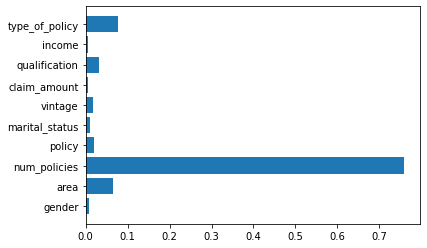

In [31]:
import matplotlib.pyplot as plt
plt.barh(features, automl.feature_importances_)